In [1]:
import rasterio
from rasterio.plot import show
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from skimage import io
import torchvision
import torchvision.transforms as T
from torchvision import tv_tensors
from torchmetrics import F1Score
import sys
from sklearn.manifold import TSNE
from torch.utils.data import Dataset
import pandas as pd
plt.style.use('seaborn-v0_8')

sys.path.append('../Models/Networks')
from U_Net import *

In [2]:
torchvision.__version__

'0.16.0'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
# These values were calculated using the histograms on notebook 01_02_DataDistributionShift.ipynb
means_CIV = [339.15884,	682.759405,	632.172002,	2872.558996]
oneperc_CIV = [217.0,	528.0,	389.0,	2162.0]
ninenine_CIV = [542.0,	896.0,	984.0,	3877.0]
std_CIV = [67.369635,	79.766812,	131.564375,	365.127796]

means_TNZ = [380.594068,	653.957063,	626.823554,	3069.664905]
oneperc_TNZ = [171.00,	442.0,	302.71,	2236.00]
ninenine_TNZ = [496.29,	805.0,	846.00,	3775.29]
std_TNZ = [63.56492,	72.122137,	103.400951,	295.013028]

class Img_Dataset(Dataset):
    def __init__(self, img_folder, transform = None, split = 'Train', norm = 'StandardScaler', VI = True):
        self.img_folder = img_folder
        self.transform = transform
        self.split = split
        self.norm = norm
        self.VI = VI

    def __len__(self):
        return sum([self.split in i for i in os.listdir(self.img_folder)])//2

    def plot_imgs(self, idx):
        fig, ax = plt.subplots(1,2,figsize = (12,6))

        im, g = self.__getitem__(idx)

        ax[0].imshow(im[[2,1,0],:,:].permute(1,2,0))
        ax[0].set_title('Planet image\nRGB')
        g = ax[1].imshow(g[0,:,:], cmap = plt.cm.get_cmap('RdYlGn', 2))
        cb = fig.colorbar(g, orientation = 'horizontal', fraction = 0.025, ticks = [0 ,1])
        cb.ax.set_xticklabels(['Background', 'Cashew'])
        ax[1].set_title('Cashew crops GT')
        
    def plot_VIs(self, idx):
        fig, ax = plt.subplots(1,2,figsize = (12,6))
        VIs = self.__getitem__(idx)[0][4:6]
        
        g1=ax[0].imshow(VIs[0], cmap = plt.cm.get_cmap('RdYlGn', 5), vmin = 0, vmax = 1)
        ax[0].set_title('NDVI')
        fig.colorbar(g1)
        g2=ax[1].imshow(VIs[1], cmap = plt.cm.get_cmap('Blues_r', 5), vmin = 0, vmax = 1)
        ax[1].set_title('NDWI')
        fig.colorbar(g2)
        
    def __getitem__(self, idx):
        #__getitem__ asks for the sample number idx.

        conversion = T.ToTensor()
        
        if 'Tanz' in self.img_folder:
            GT = io.imread(fname = self.img_folder + '/CroppedTanzania' + self.split + 'GT_{:05d}'.format(idx) + '.tif').astype(np.float32)
            img = io.imread(fname = self.img_folder + '/CroppedTanzania' + self.split + 'StudyArea_{:05d}'.format(idx) + '.tif').astype(np.float32)
        elif 'Ivor' in self.img_folder:
            GT = io.imread(fname = self.img_folder + '/CroppedIvoryCoast' + self.split + 'GT_{:05d}'.format(idx) + '.tif').astype(np.float32)
            img = io.imread(fname = self.img_folder + '/CroppedIvoryCoast' + self.split + 'StudyArea_{:05d}'.format(idx) + '.tif').astype(np.float32)

        if self.VI:
            # Should I normalize this values between 0 and 1?
            if self.norm == 'Linear_1_99':
                ndvi = ((img[:,:,3] - img[:,:,2])/(img[:,:,3] + img[:,:,2]) - 0.37)/(0.86 - (0.37))
                ndwi = ((img[:,:,1] - img[:,:,3])/(img[:,:,3] + img[:,:,1]) - (-0.79))/((-0.41) - (-0.79))
            else:
                ndvi = (img[:,:,3] - img[:,:,2])/(img[:,:,3] + img[:,:,2])
                ndwi = (img[:,:,1] - img[:,:,3])/(img[:,:,3] + img[:,:,1])

        if self.norm == 'StandardScaler':
            for i in range(img.shape[-1]):
                if 'Tanz' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - means_TNZ[i])/(std_TNZ[i])
                elif 'Ivor' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - means_CIV[i])/(std_CIV[i])

        elif self.norm == 'Linear_1_99':
            for i in range(img.shape[-1]):
                if 'Tanz' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - oneperc_TNZ[i])/(ninenine_TNZ[i] - oneperc_TNZ[i])
                elif 'Ivor' in self.img_folder:
                    img[:,:,i] = (img[:,:,i] - oneperc_CIV[i])/(ninenine_CIV[i] - oneperc_CIV[i])

        if self.VI:
            ndvi = np.expand_dims(ndvi, axis = 2)
            ndwi = np.expand_dims(ndwi, axis = 2)
            img = np.concatenate((img, ndvi, ndwi), axis = 2)

        img = conversion(img).float()

        img = tv_tensors.Image(img)

        GT = torch.flip(conversion(GT), dims = (1,))

        GT = tv_tensors.Image(GT)

        if self.transform != None:
            GT, img = self.transform(GT, img)

        return img, GT

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\mdomi\AppData\Local\Temp\ipykernel_4988\1139710227.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  g = ax[1].imshow(g[0,:,:], cmap = plt.cm.get_cmap('RdYlGn', 2))
C:\Users\mdomi\AppData\Local\Temp\ipykernel_4988\1139710227.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  g1=ax[0].imshow(VIs[0], cmap = plt.cm.get_cmap('RdYlGn', 5), vmin = 0, vmax = 1)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_4988\1139710227.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed t

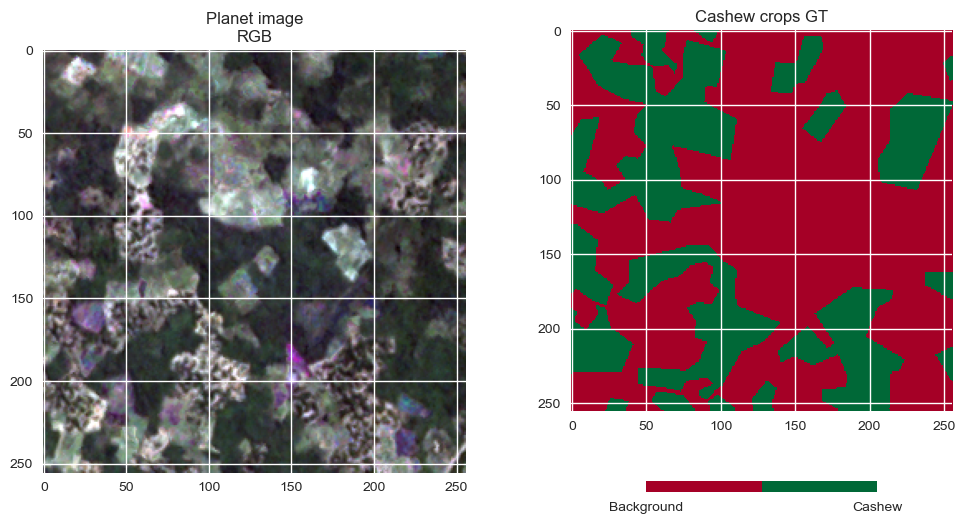

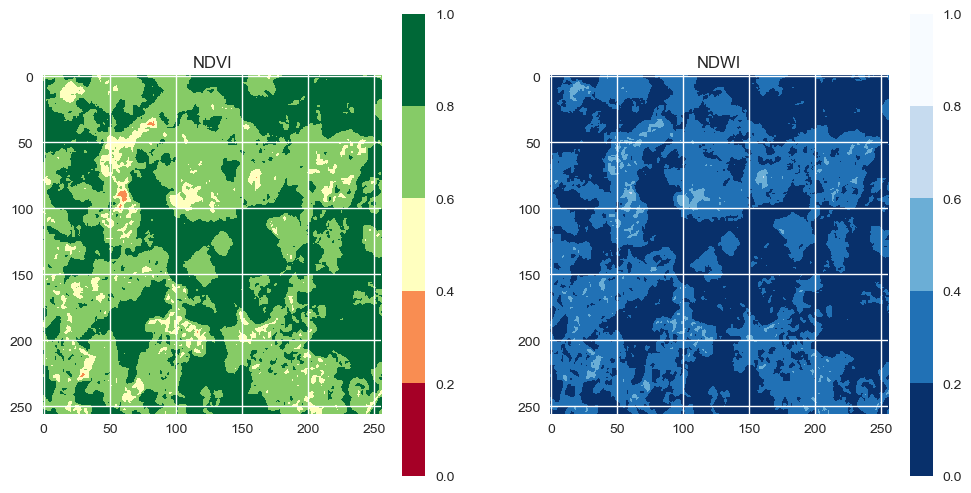

In [5]:
idx = 123
CIV = Img_Dataset('../Data/Planet/Tanzania_2015_2018/', norm = 'Linear_1_99')
CIV.plot_imgs(idx)

CIV.plot_VIs(idx)

## Visual assessment of distance between features extracted

In [6]:
Use_VI = False
normalization = 'Linear_1_99'

In [7]:
batch_size = 2

model = torch.load('../Models/Experiments/Linear_1_99_Normalization/BestModel.pt')
model.eval()

CIV_FE = []
TNZ_FE = []

CIV_te = Img_Dataset('../Data/Planet/IvoryCoast_2015_2018/', split = 'Validation', VI = Use_VI, norm = normalization)
TNZ_te = Img_Dataset('../Data/Planet/Tanzania_2015_2018/', split = 'Validation', VI = Use_VI, norm = normalization)

CIV_test_loader = torch.utils.data.DataLoader(dataset=CIV_te, batch_size=batch_size, shuffle=False)
TNZ_test_loader = torch.utils.data.DataLoader(dataset=TNZ_te, batch_size=batch_size, shuffle=False)

CIV_iterable_test_loader = enumerate(CIV_test_loader)
TNZ_iterable_test_loader = enumerate(TNZ_test_loader)

for i, (imgs, GTs) in CIV_iterable_test_loader:
    
    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        CIV_FE.append(features[j].flatten().cpu().detach().numpy())

for i, (imgs, GTs) in TNZ_iterable_test_loader:
    
    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        TNZ_FE.append(features[j].flatten().cpu().detach().numpy())
        
CIV_te = Img_Dataset('../Data/Planet/IvoryCoast_2015_2018/', split = 'Test', VI = Use_VI, norm = normalization)
TNZ_te = Img_Dataset('../Data/Planet/Tanzania_2015_2018/', split = 'Test', VI = Use_VI, norm = normalization)

CIV_test_loader = torch.utils.data.DataLoader(dataset=CIV_te, batch_size=batch_size, shuffle=False)
TNZ_test_loader = torch.utils.data.DataLoader(dataset=TNZ_te, batch_size=batch_size, shuffle=False)

CIV_iterable_test_loader = enumerate(CIV_test_loader)
TNZ_iterable_test_loader = enumerate(TNZ_test_loader)

for i, (imgs, GTs) in CIV_iterable_test_loader:
    
    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        CIV_FE.append(features[j].flatten().cpu().detach().numpy())

for i, (imgs, GTs) in TNZ_iterable_test_loader:
    
    features = model.FE(imgs.to(device))
    for j in range(features.shape[0]):
        TNZ_FE.append(features[j].flatten().cpu().detach().numpy())

In [ ]:
df_ = pd.DataFrame(TNZ_FE)
df_['domain'] = 'target'
df = pd.DataFrame(CIV_FE)
df['domain'] = 'source'
# df = df.sample(len(df_), random_state = 8) #  To get same amount of images per domain

In [ ]:
df = pd.concat([df, df_])
X = df.iloc[:,:-1]

In [ ]:
comps = 2

tsne = TSNE(comps, perplexity = 50, n_iter =  1500, random_state=8)

FE_tsne = tsne.fit_transform(X)

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (9.5,5))

sns.scatterplot(x = FE_tsne[:,0], y = FE_tsne[:,1], hue = df['domain'], ax = ax, palette = ['darkblue', 'darkred'])

ax.set_title('t-SNE of features extracted for test and validation datasets\nof each domain using Source-Only 4 Up-Layer model')

fig.savefig('../imgs/t_SNE_SourceOnly.png')

## Mean euclidean distance

In [19]:
mean_domains = df.groupby('domain').mean().T

euc_dist = np.sqrt(np.sum((mean_domains['source'] - mean_domains['target'])**2))

In [20]:
euc_dist

251.67137

In [ ]:
for i in range(len(df[df['domain'] == 'target'])):
    np.sqrt(np.sum((df[df['domain'] == 'source'] - df[df['domain'] == 'target'].iloc[0])**2, axis = 1))

In [82]:
distances = [72, 182, 118, 127]

In [13]:
model

NameError: name 'Model' is not defined